In [87]:
import nbimporter
import pandas as pd
import numpy as np

In [89]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [91]:
class MomVectorBacktester(object):
    def __init__(self,symbol,start,end,amount,tc):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.amount = amount
        self.tc= tc
        self.results = None
        self.get_data() 

    def get_data(self):
        raw = pd.read_csv('https://hilpisch.com/pyalgo_eikon_eod_data.csv',index_col=0,parse_dates=True).dropna()
        raw = pd.DataFrame(raw[self.symbol])
        raw = raw.loc[self.start:self.end]
        raw.rename(columns = {self.symbol:'price'},inplace=True)
        raw['return'] = np.log(raw/raw.shift(1))
        self.data = raw

    def run_strategy(self,momentum=1):
        self.momentum = momentum
        data = self.data.copy().dropna()
        data['position'] = np.sign(data['return'].rolling(momentum).mean())
        data['strategy'] = data['position'].shift(1) * data['return']
        data.dropna(inplace=True)
        trades = data['position'].diff().fillna(0) !=0
        data['strategy'][trades] -= self.tc
        data['creturns'] = self.amount*data['return'].cumsum().apply(np.exp)
        data['cstrategy'] = self.amount * data['strategy'].cumsum().apply(np.exp)
        self.results = data
        aperf = self.results['cstrategy'].iloc[-1]
        operf = aperf - self.results['cstrategy'].iloc[-1]
        return round(aperf,2), round(operf,2)

    def plot_results(self):
        if self.results is None:
            print('No results to plot yet. Run a strategy')

        title = '%s | TC=%.4f' % (self.symbol,self.tc)
        self.results[['creturns','cstrategy']].plot(title=title,figsize=(10,6))

In [93]:
class MRVectorBacktester(MomVectorBacktester):
    
    def run_strategy(self,SMA,threshold):
        data = self.data.copy().dropna()
        data['sma'] = data['price'].rolling(SMA).mean()
        data['distance'] = data['price'] - data['sma']
        data.dropna(inplace=True)
        #selling signals
        data['position'] = np.where(data['distance']>threshold, -1, np.nan)
        #buy signals
        data['position'] = np.where(data['distance']<-threshold,1,data['position'])
        #crossing of current price and SMA (zerp distance)
        data['position'] = np.where(data['distance']*data['distance'].shift(1)<0,0,data['position'])
        data['position'] = data['position'].ffill().fillna(0)
        data['strategy'] = data['position'].shift(1) * data['return']
        data['creturns'] = self.amount * data['return'].cumsum().apply(np.exp)
        trades = data['position'].diff().fillna(0) !=0
        data['strategy'][trades] -= self.tc
        data['cstrategy'] = self.amount * data['strategy'].cumsum().apply(np.exp)
        self.results = data
        aperf = self.results['cstrategy'].iloc[-1]
        operf = aperf - self.results['creturns'].iloc[-1]
        return round(aperf,2),round(operf,2)
    

In [95]:
mrbt = MRVectorBacktester('GLD','2010-1-1','2019-12-31',1000,0.001)

In [97]:
mrbt.run_strategy(SMA=43,threshold=7.5)

(1354.22, 64.62)

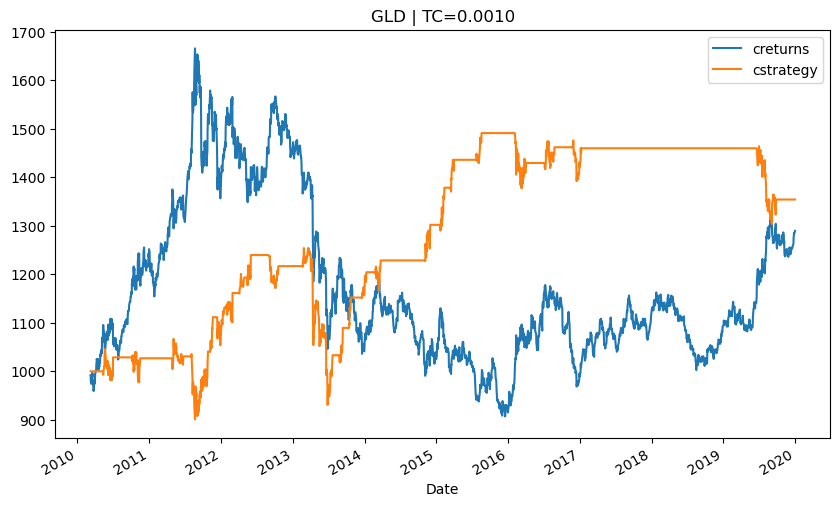

In [99]:
mrbt.plot_results()